In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", message="Workbook contains no default style, apply openpyxl's default")
warnings.simplefilter(action='ignore', category=FutureWarning)


folder_path = 'TothSpreadsheets'

In [8]:
# Function to read all spreadsheets in a folder and extract labels from the first column
def extract_instrument_counts(folder_path):
    instruments_count = {}
    for file_name in os.listdir(folder_path):
        # if starts with 'Toth' and ends with .xlsx
        if file_name.startswith('Toth') and (file_name.endswith('.xlsx') or file_name.endswith('.xls')):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_excel(file_path)
            labels = df.iloc[2:, 0].tolist()  # Assuming you want to skip the first two rows
            for label in labels:
                instruments_count[label] = instruments_count.get(label, 0) + 1

    # returns a dictionary with labels as keys and their counts as values
    return instruments_count



In [9]:
instruments_count = extract_instrument_counts(folder_path)
print(instruments_count)


{nan: 49, 'Jegogan': 94, 'Calung': 99, 'Giying': 76, 'Pemade': 178, 'Kantilan': 146, 'Reyong': 57, 'Trompong': 62, 'Penyacah': 37}


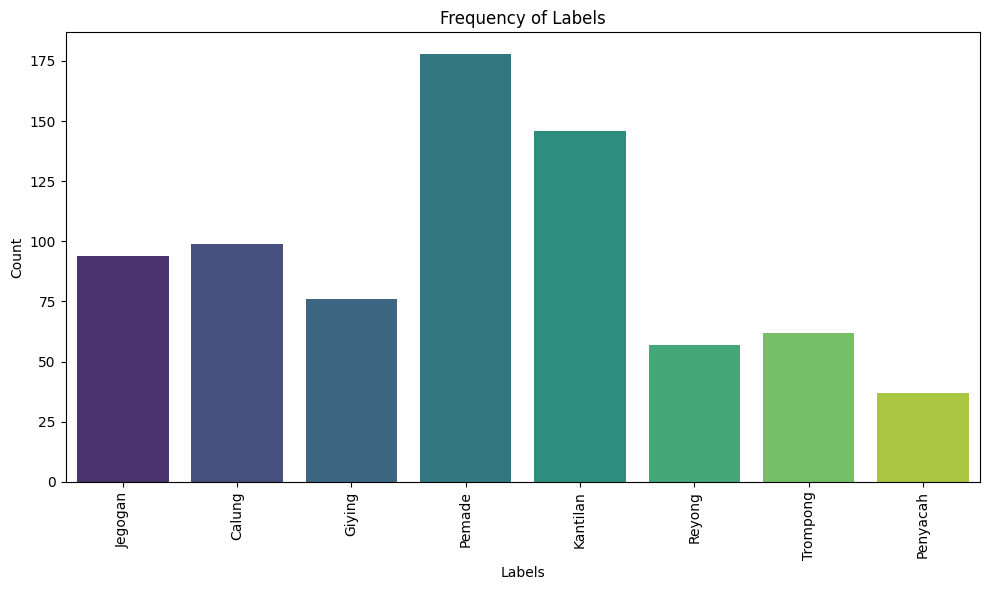

In [10]:

# Convert dictionary to DataFrame for seaborn
data = pd.DataFrame({'Labels': list(instruments_count.keys()), 'Count': list(instruments_count.values())})

# Plotting the data with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Labels', y='Count', data=data, palette='viridis')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Frequency of Labels')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [13]:


def classify_pairs(folder_path):
    classification = {}
    for file_name in os.listdir(folder_path):
        if file_name.startswith('Toth') and (file_name.endswith('.xlsx') or file_name.endswith('.xls')):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_excel(file_path)
            # starting from the 3rd row
            for _, row in df.iloc[2:].iterrows():
                label = row[0]
                value = row[1]
                if label not in classification:
                    classification[label] = {'pengisep': 0, 'pengumbang': 0}
                if value == '+':
                    classification[label]['pengisep'] += 1
                elif value == '-':
                    classification[label]['pengumbang'] += 1

    return classification

In [14]:
# Classify the labels based on the values in the second column
classification = classify_pairs(folder_path)
print(classification)



{nan: {'pengisep': 0, 'pengumbang': 0}, 'Jegogan': {'pengisep': 46, 'pengumbang': 48}, 'Calung': {'pengisep': 49, 'pengumbang': 50}, 'Giying': {'pengisep': 38, 'pengumbang': 38}, 'Pemade': {'pengisep': 88, 'pengumbang': 90}, 'Kantilan': {'pengisep': 72, 'pengumbang': 74}, 'Reyong': {'pengisep': 18, 'pengumbang': 39}, 'Trompong': {'pengisep': 34, 'pengumbang': 28}, 'Penyacah': {'pengisep': 19, 'pengumbang': 18}}


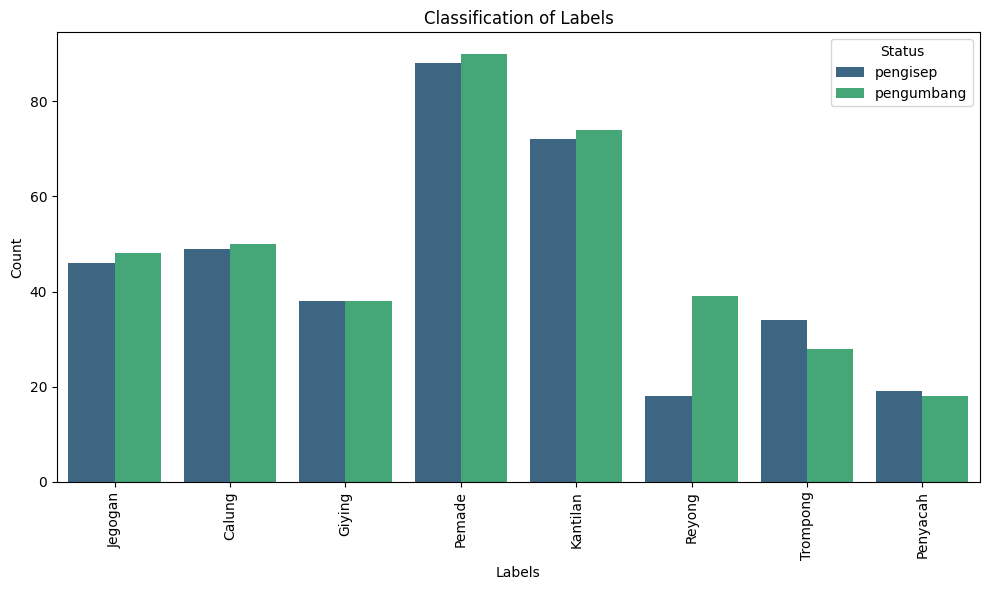

In [15]:

# Convert dictionary to DataFrame for seaborn
data = pd.DataFrame([(label, status, count) for label, status_dict in classification.items() for status, count in status_dict.items()],
                    columns=['Labels', 'Status', 'Count'])

# Plotting the data with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Labels', y='Count', hue='Status', data=data, palette='viridis')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Classification of Labels')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [51]:
# define a function that will read all spreadsheets in a folder and extract the data from the first two columns
def extract_instrument_data(folder_path):
    data = {}
    for file_name in os.listdir(folder_path):
        if file_name.startswith('Toth') and ((file_name.endswith('.xlsx') or file_name.endswith('.xls'))):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_excel(file_path)
            # extract the label of the cell            
            gamelan_name = df.iloc[0,0]
            # extract the data from the first two columns
            data[gamelan_name] = df.iloc[3:, :2]

    for gamelan_name, df in data.items():
        print(f'\n{gamelan_name}')
        print(df)
        
    return data



In [53]:
instruments_gamelan = extract_instrument_data(folder_path)
print(instruments_gamelan)



Badung
        Sima Unnamed: 1
3    Jegogan          -
4     Calung          -
5     Giying          -
6     Pemade          -
7     Pemade          -
8   Kantilan          -
9   Kantilan          -
10    Reyong          -
11  Trompong          -
12   Jegogan          +
13    Calung          +
14    Giying          +
15    Pemade          +
16    Pemade          +
17  Kantilan          +
18  Kantilan          +
19    Reyong          +
20  Trompong          +

Gianyar
    Sumampan Unnamed: 1
3    Jegogan          -
4     Calung          -
5     Giying          -
6     Pemade          -
7     Pemade          -
8   Kantilan          -
9   Kantilan          -
10   Jegogan          +
11    Calung          +
12    Giying          +
13    Pemade          +
14  Kantilan          +
15  Kantilan          +

Karangasem
     Sidemen Unnamed: 1
3    Jegogan          -
4     Calung          -
5     Giying          -
6     Pemade          -
7   Kantilan          -
8   Trompong          -
9    Jegoga

In [ ]:
# count the number of gamelans in which each + and - instrument appears
def count_instruments_appearances(data):
    appearances = {}
    for gamelan_name, df in data.items():
        for _, row in df.iterrows():
            label = row[0]
            value = row[1]
            # check if the label appears at least once in the dictionary
            if label not in appearances:
                appearances[label] = {'pengisep': 0, 'pengumbang': 0}
            if value == '+':
                appearances[label]['pengisep'] = 1
            elif value == '-':
                appearances[label]['pengumbang'] = 1


    return appearances
    
            

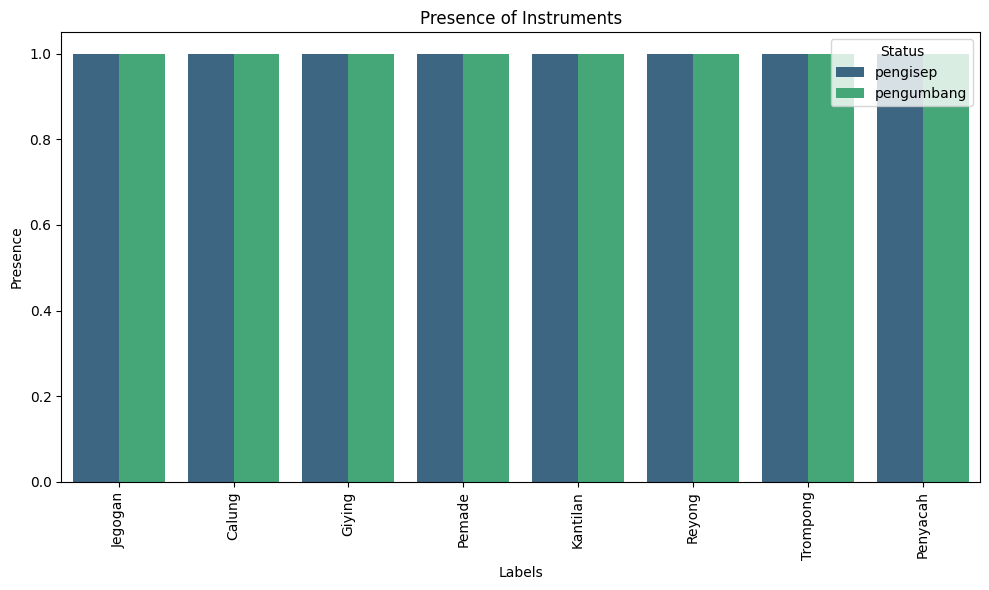

In [22]:
# convert dictionary to DataFrame for seaborn
data = pd.DataFrame([(label, status, presence) for label, status_dict in instrument_presence.items() for status, presence in status_dict.items()],
                    columns=['Labels', 'Status', 'Presence'])

# Plotting the data with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Labels', y='Presence', hue='Status', data=data, palette='viridis')
plt.xlabel('Labels')
plt.ylabel('Presence')
plt.title('Presence of Instruments')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load the Excel file into a DataFrame
df = pd.read_excel('your_excel_file.xlsx')

# Get the third row (excluding the labels row)
keys = df.iloc[2]

# Initialize the dictionary
result_dict = {}

# Loop through the DataFrame to find rows where the first element matches 'desired_label_name'
for index, row in df.iterrows():
    if row.iloc[0] == 'desired_label_name':
        # Key is the third row values
        key = keys.tolist()
        # Value is the row excluding the first three elements
        value = row.tolist()[3:]
        # If there's no value, assign None
        value = [None if pd.isnull(v) else v for v in value]
        # Assign labels if the first two elements are None
        if pd.isnull(row.iloc[1]) and pd.isnull(row.iloc[2]):
            key[0] = 'instruments'
            key[1] = 'void'
        # Convert the third row values to a tuple to use as key
        key = tuple(key)
        # Append the value to the list corresponding to the key
        if key in result_dict:
            result_dict[key].append(value)
        else:
            result_dict[key] = [value]

print(result_dict)